# KI/PZS – Seminární práce I (2025/2026)


In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import signal
import wfdb

## 1) Nastavení cest k datům


```
F:/PZS/data/
├─ charisdb/charis-database-1.0.0/
├─ drivedb/stress-recognition-in-automobile-drivers-1.0.0/
└─ nsrdb/mit-bih-normal-sinus-rhythm-database-1.0.0/
```


In [2]:
BASE_DIR = Path(r"F:/PZS/data") 

CHARIS_DIR = BASE_DIR/"charisdb"/"charis-database-1.0.0"
DRIVE_DIR  = BASE_DIR/"drivedb"/"stress-recognition-in-automobile-drivers-1.0.0"
NSR_DIR    = BASE_DIR/"nsrdb"/"mit-bih-normal-sinus-rhythm-database-1.0.0"

## 2) Pomocné funkce (preprocessing, R-peaky, metriky)

### Co budu dělat
- **Centralizace**: odečtení střední hodnoty (signál kolem osy).
- **Interpolace NaN**: chybějící data doplníme lineární interpolací.
- **Převzorkování**: když nemají signály stejnou vzorkovací frekvenci, převedeme na `target_fs`.
- **Detekce R-vrcholů**: jednoduchá verze Pan–Tompkins (bandpass → derivace → kvadrát → klouzavá integrace → adaptivní práh).
- **HR**: z R-R intervalů nebo počet R v 60 s okně.


In [ ]:
def interpolate_nans(x: np.ndarray) -> np.ndarray:
    """Lineární interpolace NaN hodnot. Pokud nejsou NaN, vrátí kopii."""
    x = np.asarray(x, dtype=float)
    if not np.isnan(x).any():
        return x.copy()
    n = len(x)
    idx = np.arange(n)
    good = ~np.isnan(x)
    if good.sum() < 2:
        # nelze smysluplně interpolovat
        return np.nan_to_num(x, nan=np.nanmean(x) if good.sum() else 0.0)
    return np.interp(idx, idx[good], x[good])

def centralize(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x, dtype=float)
    return x - np.nanmean(x)

def resample_to_fs(x: np.ndarray, fs_in: float, fs_out: float) -> np.ndarray:
    """Převzorkování pomocí resample_poly (stabilní a rychlé)."""
    if fs_in == fs_out:
        return np.asarray(x, dtype=float)
    # aproximaci přes gcd na celých číslech
    up = int(round(fs_out * 100))
    down = int(round(fs_in * 100))
    g = np.gcd(up, down)
    up //= g
    down //= g
    return signal.resample_poly(np.asarray(x, dtype=float), up, down)

def bandpass_filter(x: np.ndarray, fs: float, low: float = 5.0, high: float = 15.0, order: int = 3):
    nyq = 0.5 * fs

    # ochrana proti špatným mezím
    high_eff = min(high, 0.45 * fs)   # max 90 % Nyquista
    low_eff  = min(low, high_eff * 0.8)

    low_n = low_eff / nyq
    high_n = high_eff / nyq

    if not (0 < low_n < high_n < 1):
        raise ValueError(f"Neplatné meze filtru: fs={fs}, low_n={low_n}, high_n={high_n}")

    b, a = signal.butter(order, [low_n, high_n], btype="bandpass")
    return signal.filtfilt(b, a, x)


def moving_average(x: np.ndarray, win_samples: int) -> np.ndarray:
    win_samples = max(1, int(win_samples))
    kernel = np.ones(win_samples) / win_samples
    return np.convolve(x, kernel, mode='same')

def detect_r_peaks(ecg: np.ndarray, fs: float, refractory_s: float = 0.45):
    """
    Detekce R-vrcholů (vlastní algoritmus):
    1) bandpass 5-15 Hz
    2) derivace
    3) umocnění
    4) klouzavá integrace (~150 ms)
    5) adaptivní práh + refrakterní doba
    Vrací indexy vzorků R-vrcholů.
    """
    x = interpolate_nans(ecg)
    x = centralize(x)
    x_f = bandpass_filter(x, fs, 5.0, 15.0, order=3)

    # derivace (zvýrazní strmost QRS)
    dx = np.diff(x_f, prepend=x_f[0])
    sq = dx**2

    # integrace (okno cca 150 ms)
    win = int(0.150 * fs)
    mwi = moving_average(sq, win)

    # adaptivní práh (robustně přes percentil)
    thr = np.percentile(mwi, 97) * 0.5  # doladitelné

    # najdi kandidáty jako lokální maxima nad prahem
    distance = int(refractory_s * fs)
    peaks, props = signal.find_peaks(mwi, height=thr, distance=distance)

    # pro každý peak z mwi najdi skutečný R v okolí v původním filtrovaném signálu
    r_peaks = []
    search = int(0.12 * fs)  # ±120 ms
    for p in peaks:
        a = max(0, p - search)
        b = min(len(x_f), p + search)
        # R je maximum v bandpass signálu
        rp = a + int(np.argmax(x_f[a:b]))
        r_peaks.append(rp)
    r_peaks = np.array(sorted(set(r_peaks)), dtype=int)
    return r_peaks

def hr_from_rpeaks(r_peaks: np.ndarray, fs: float) -> float:
    """HR z RR intervalů jako 60 / median(RR)."""
    if len(r_peaks) < 2:
        return np.nan
    rr = np.diff(r_peaks) / fs
    rr = rr[(rr > 0.4) & (rr < 1.5)]  # rozumné RR
    if len(rr) == 0:
        return np.nan
    return 60.0 / np.median(rr)

def hr_per_minute(r_peaks: np.ndarray, fs: float, n_samples: int) -> pd.DataFrame:
    """Počet R vrcholů v každé minutě -> BPM."""
    minutes = int(np.ceil(n_samples / (60*fs)))
    rows = []
    for m in range(minutes):
        start = int(m * 60 * fs)
        end = int(min((m+1) * 60 * fs, n_samples))
        count = np.sum((r_peaks >= start) & (r_peaks < end))
        bpm = count  # počet tepů za minutu
        rows.append((m, start/fs, end/fs, count, bpm))
    return pd.DataFrame(rows, columns=["minute_idx","t_start_s","t_end_s","r_count","bpm"])

def match_peaks(ref: np.ndarray, pred: np.ndarray, tol_s: float, fs: float):
    """Spáruje predikované vrcholy s referencí v toleranci tol_s. Vrací TP, FP, FN."""
    tol = int(tol_s * fs)
    ref = np.asarray(ref, dtype=int)
    pred = np.asarray(pred, dtype=int)
    used = np.zeros(len(ref), dtype=bool)

    tp = 0
    for p in pred:
        # najdi nejbližší referenční vrchol
        i = np.argmin(np.abs(ref - p)) if len(ref) else None
        if i is not None and abs(ref[i] - p) <= tol and not used[i]:
            tp += 1
            used[i] = True

    fp = len(pred) - tp
    fn = len(ref) - tp
    return tp, fp, fn

def detection_metrics(tp, fp, fn):
    se = tp / (tp + fn) if (tp + fn) else np.nan  # sensitivity (recall)
    ppv = tp / (tp + fp) if (tp + fp) else np.nan # precision
    f1 = 2*ppv*se/(ppv+se) if (ppv+se) else np.nan
    return {"TP":tp,"FP":fp,"FN":fn,"Se":se,"PPV":ppv,"F1":f1}


## 3) Vyhledání záznamů (automaticky)

Najdu všechny `*.hea` soubory a z nich uděláme seznam záznamů pro:
- drivedb (měření řidičů)
- nsrdb (MIT-BIH testovací záznamy)
- charisdb (pacienti)


In [4]:
def list_records(db_dir: Path):
    """Vrátí seznam record pathů bez přípony (tak jak to chce wfdb.rdrecord)."""
    db_dir = Path(db_dir)
    headers = sorted(db_dir.rglob("*.hea"))
    records = [h.with_suffix("") for h in headers]
    return records

drive_records = list_records(DRIVE_DIR) if DRIVE_DIR.exists() else []
nsr_records   = list_records(NSR_DIR)   if NSR_DIR.exists() else []
charis_records= list_records(CHARIS_DIR) if CHARIS_DIR.exists() else []

print("drivedb records:", len(drive_records))
print("nsrdb records  :", len(nsr_records))
print("charisdb recs  :", len(charis_records))

# ukaž pár příkladů
print("sample drivedb:", drive_records[:3])
print("sample nsrdb  :", nsr_records[:3])
print("sample charis :", charis_records[:3])


drivedb records: 18
nsrdb records  : 18
charisdb recs  : 13
sample drivedb: [WindowsPath('F:/PZS/data/drivedb/stress-recognition-in-automobile-drivers-1.0.0/drive01'), WindowsPath('F:/PZS/data/drivedb/stress-recognition-in-automobile-drivers-1.0.0/drive02'), WindowsPath('F:/PZS/data/drivedb/stress-recognition-in-automobile-drivers-1.0.0/drive03')]
sample nsrdb  : [WindowsPath('F:/PZS/data/nsrdb/mit-bih-normal-sinus-rhythm-database-1.0.0/16265'), WindowsPath('F:/PZS/data/nsrdb/mit-bih-normal-sinus-rhythm-database-1.0.0/16272'), WindowsPath('F:/PZS/data/nsrdb/mit-bih-normal-sinus-rhythm-database-1.0.0/16273')]
sample charis : [WindowsPath('F:/PZS/data/charisdb/charis-database-1.0.0/charis1'), WindowsPath('F:/PZS/data/charisdb/charis-database-1.0.0/charis10'), WindowsPath('F:/PZS/data/charisdb/charis-database-1.0.0/charis11')]


# Úloha 1 – Výpočet tepové frekvence z EKG (drivedb)

### Cíl
1) Načíst EKG signál z drivedb (17 měření).  
2) Automaticky detekovat R-vrcholy.  
3) Spočítat tepovou frekvenci (BPM) pro jednotlivá měření.  
4) Vykreslit graf (BPM vs. měření) + tabulku výsledků.



In [5]:
def pick_ecg_channel(record) -> int:
    names = [n.upper() for n in (record.sig_name or [])]
    for i, n in enumerate(names):
        if "ECG" in n or "EKG" in n:
            return i
    return 0

def load_signal(record_path: Path):
    rec = wfdb.rdrecord(str(record_path))
    fs = float(rec.fs)
    sig = rec.p_signal
    ch = pick_ecg_channel(rec)
    x = sig[:, ch]
    return x, fs, rec

results = []
for rp in drive_records:
    try:
        x, fs, rec = load_signal(rp)
        r = detect_r_peaks(x, fs)
        bpm = hr_from_rpeaks(r, fs)
        results.append({
            "zaznam": rp.name,
            "fs": fs,
            "pocet_vzorku": len(x),
            "delka_s": len(x)/fs,
            "pocet_r_vrcholu": len(r),
            "teppova_frekvence": bpm,
        })
    except Exception as e:
        results.append({"zaznam": rp.name, "error": str(e)})

df_drive = pd.DataFrame(results).sort_values("zaznam")
df_drive.head(10)


,zaznam,fs,pocet_vzorku,delka_s,pocet_r_vrcholu,teppova_frekvence
0,drive01,15.5,61499,3967.677419,4168,84.545455
1,drive02,15.5,78056,5035.870968,3086,66.428571
2,drive03,31.0,172447,5562.806452,5194,74.400000
3,drive04,15.5,76266,4920.387097,4291,77.500000
4,drive05,15.5,78367,5055.935484,4063,77.500000
5,drive06,15.5,75123,4846.645161,4951,84.545455
6,drive07,15.5,82442,5318.838710,4885,71.538462
7,drive08,15.5,75509,4871.548387,3233,66.428571
8,drive09,15.5,65912,4252.387097,3432,66.428571
9,drive10,15.5,75592,4876.903226,4898,77.500000


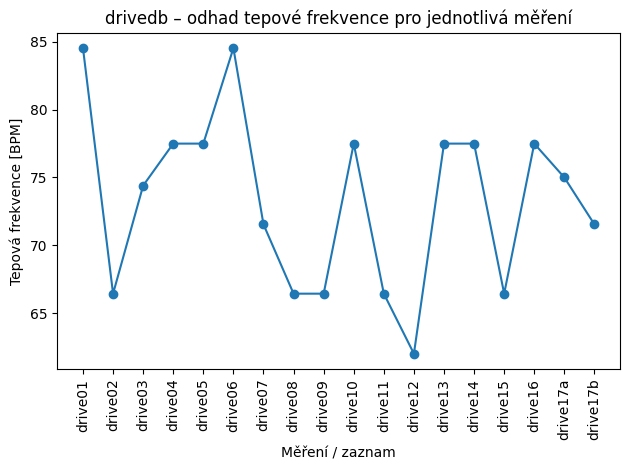

,zaznam,fs,teppova_frekvence,pocet_r_vrcholu,delka_s
0,drive01,15.5,84.545455,4168,3967.677419
1,drive02,15.5,66.428571,3086,5035.870968
2,drive03,31.0,74.400000,5194,5562.806452
3,drive04,15.5,77.500000,4291,4920.387097
4,drive05,15.5,77.500000,4063,5055.935484
5,drive06,15.5,84.545455,4951,4846.645161
6,drive07,15.5,71.538462,4885,5318.838710
7,drive08,15.5,66.428571,3233,4871.548387
8,drive09,15.5,66.428571,3432,4252.387097
9,drive10,15.5,77.500000,4898,4876.903226


In [6]:
# Graf BPM vs. měření (pokud jsou výsledky)
df_ok = df_drive.dropna(subset=["teppova_frekvence"]).copy()
df_ok = df_ok[~df_ok["teppova_frekvence"].isna()]

plt.figure()
plt.plot(df_ok["zaznam"], df_ok["teppova_frekvence"], marker='o', linestyle='-')
plt.xticks(rotation=90)
plt.ylabel("Tepová frekvence [BPM]")
plt.xlabel("Měření / zaznam")
plt.title("drivedb – odhad tepové frekvence pro jednotlivá měření")
plt.tight_layout()
plt.show()

df_ok[["zaznam","fs","teppova_frekvence","pocet_r_vrcholu","delka_s"]].reset_index(drop=True)

## Ukázka: detail jednoho záznamu (signál + R vrcholy + BPM po minutách)

Vyberu jeden record a ukážu:
- EKG (krátký úsek)
- detekované R vrcholy
- BPM po minutách (počtem R v 60 s oknech)


,minute_idx,t_start_s,t_end_s,r_count,bpm
0,0,0.0,60.0,67,67
1,1,60.0,120.0,63,63
2,2,120.0,180.0,70,70
3,3,180.0,240.0,63,63
4,4,240.0,300.0,60,60


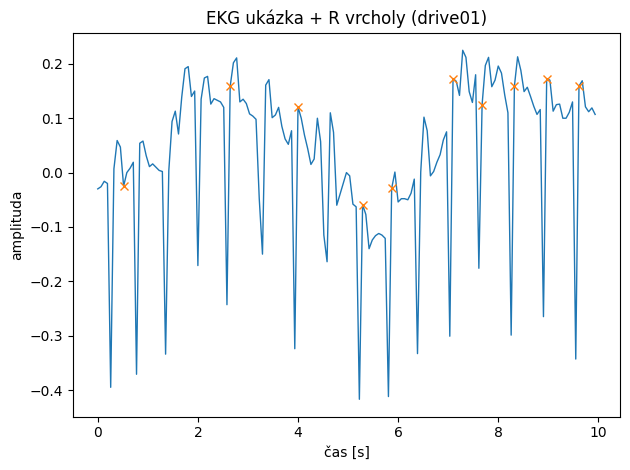

In [8]:
if len(drive_records) == 0:
    print("Nenalezeny žádné drivedb records. Zkontroluj cestu DRIVE_DIR.")
else:
    rp = drive_records[0]  
    x, fs, rec = load_signal(rp)
    r = detect_r_peaks(x, fs)

    # BPM po minutách
    df_min = hr_per_minute(r, fs, len(x))
    display(df_min.head())

    # vykresli 10 s ukázku
    t0 = 0
    t1 = min(int(10*fs), len(x))
    ts = np.arange(t0, t1)/fs

    plt.figure()
    plt.plot(ts, x[t0:t1], linewidth=1)
    # R peaky v okně
    r_win = r[(r>=t0) & (r<t1)]
    plt.plot((r_win)/fs, x[r_win], 'x')
    plt.title(f"EKG ukázka + R vrcholy ({rp.name})")
    plt.xlabel("čas [s]")
    plt.ylabel("amplituda")
    plt.tight_layout()
    plt.show()


#  Úloha 1 – Test úspěšnosti na MIT-BIH (nsrdb)

### Postup
1) Načti záznam + anotace (`atr`) z nsrdb.  
2) Detekuj R vrcholy (stejný algoritmus).  
3) Spáruj predikované vrcholy s referenčními v toleranci (např. **±100 ms**).  
4) Spočítej metriky: **Se (recall), PPV (precision), F1**.


In [9]:
TOL_S = 0.10  # 100 ms tolerance

eval_rows = []
for rp in nsr_records:
    try:
        rec = wfdb.rdrecord(str(rp))
        fs = float(rec.fs)
        # vezmeu jen prvních 5 minut
        MAX_MINUTES = 5
        n = int(MAX_MINUTES * 60 * fs)

        x = rec.p_signal[:n, pick_ecg_channel(rec)]

        ann = wfdb.rdann(str(rp), "atr")
        ref = np.array(ann.sample, dtype=int)
        ref = ref[ref < n]


        pred = detect_r_peaks(x, fs)

        tp, fp, fn = match_peaks(ref, pred, tol_s=TOL_S, fs=fs)
        m = detection_metrics(tp, fp, fn)
        eval_rows.append({"zaznam": rp.name, "fs": fs, **m})
    except Exception as e:
        eval_rows.append({"zaznam": rp.name, "error": str(e)})

df_eval = pd.DataFrame(eval_rows).sort_values("zaznam")
df_eval.head(10)


,zaznam,fs,TP,FP,FN,Se,PPV,F1
0,16265,128.0,481,0,3,0.993802,1.0,0.996891
1,16272,128.0,334,0,18,0.948864,1.0,0.973761
2,16273,128.0,461,0,9,0.980851,1.0,0.990333
3,16420,128.0,448,0,22,0.953191,1.0,0.976035
4,16483,128.0,455,0,12,0.974304,1.0,0.986985
5,16539,128.0,428,0,4,0.990741,1.0,0.995349
6,16773,128.0,394,0,245,0.616588,1.0,0.762827
7,16786,128.0,370,0,3,0.991957,1.0,0.995962
8,16795,128.0,335,0,92,0.784543,1.0,0.879265
9,17052,128.0,387,0,3,0.992308,1.0,0.996139


Záznamů vyhodnoceno: 18 / 18


,Se,PPV,F1
count,18.000000,18.000000,18.000000
mean,0.897817,0.999741,0.942529
std,0.109065,0.001099,0.065293
min,0.616588,0.995338,0.762827
25%,0.854357,1.000000,0.921459
50%,0.950928,1.000000,0.974845
75%,0.988268,1.000000,0.994095
max,0.995294,1.000000,0.997642


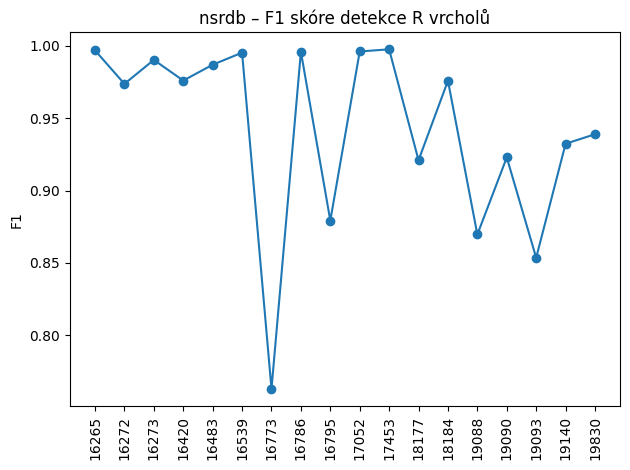

In [16]:
# Souhrn metrik
df_eval_ok = df_eval.dropna(subset=["F1"]).copy()
print("Záznamů vyhodnoceno:", len(df_eval_ok), "/", len(df_eval))
display(df_eval_ok[["Se","PPV","F1"]].describe())

plt.figure()
plt.plot(df_eval_ok["zaznam"], df_eval_ok["F1"], marker='o')
plt.xticks(rotation=90)
plt.ylabel("F1")
plt.title("nsrdb – F1 skóre detekce R vrcholů")
plt.tight_layout()
plt.show()


#  Úloha 2 – Korelace měřených signálů (charisdb)

### Cíl
Pro každého pacienta (13):
1) Načti 3 signály: **EKG, ABP, ICP**.  
2) Ověř stejnou vzorkovací frekvenci, případně převzorkuj na `target_fs`.  
3) Centralizuj signály (odečti průměr).  
4) Vyhodnoť vždy **první hodinu** signálu.  
5) Chybějící data (NaN) nahraď interpolací.  
6) Spočítej korelace mezi EKG–ABP–ICP pro každého pacienta.  
7) Mezi pacienty spočítej korelaci jejich **ABP** signálů (po zarovnání na stejný počátek podle dominantního vrcholu).


In [ ]:
TARGET_FS = 125.0  # vzorkovací frekvence

def first_hour(x: np.ndarray, fs: float) -> np.ndarray:
    n = int(min(len(x), 3600 * fs))
    return x[:n]

def preprocess_signal(x: np.ndarray) -> np.ndarray:
    x = interpolate_nans(x)
    x = centralize(x)
    return x

def load_charis_patient(record_path: Path):
    rec = wfdb.rdrecord(str(record_path))
    fs = float(rec.fs)
    sig = rec.p_signal
    names = rec.sig_name or []
    return sig, fs, names

def get_channel_by_name(names, keywords):
    names_u = [n.upper() for n in names]
    for k in keywords:
        ku = k.upper()
        for i, n in enumerate(names_u):
            if ku in n:
                return i
    return None

def dominant_peak_align(x: np.ndarray, fs: float, search_s: float = 10.0):
    """Najde dominantní vrchol v prvních `search_s` sekundách a posune signál tak, aby peak byl na začátku."""
    n = int(min(len(x), search_s*fs))
    seg = x[:n]
    # Vrchol jako maximum (ABP má často výrazný systolický peak)
    p = int(np.argmax(seg))
    return np.roll(x, -p), p

# 2.1 Korelace v rámci pacienta (EKG, ABP, ICP)
patient_rows = []
patient_signals = {}  # uložím ABP po předzpracování a resamplingu pro pozdější korelaci mezi pacienty

for rp in charis_records:
    try:
        sig, fs, names = load_charis_patient(rp)

        # pokus o automatické mapování kanálů
        idx_ecg = get_channel_by_name(names, ["ECG", "EKG"]) or 0
        idx_abp = get_channel_by_name(names, ["ABP"]) 
        idx_icp = get_channel_by_name(names, ["ICP"])

        if idx_abp is None or idx_icp is None:
            raise ValueError(f"Nejsem si jistý kanály ABP/ICP. names={names}")

        ecg = sig[:, idx_ecg]
        abp = sig[:, idx_abp]
        icp = sig[:, idx_icp]

        # první hodina + preprocessing
        ecg = preprocess_signal(first_hour(ecg, fs))
        abp = preprocess_signal(first_hour(abp, fs))
        icp = preprocess_signal(first_hour(icp, fs))

        # resampling na TARGET_FS (pokud je potřeba)
        ecg_r = resample_to_fs(ecg, fs, TARGET_FS)
        abp_r = resample_to_fs(abp, fs, TARGET_FS)
        icp_r = resample_to_fs(icp, fs, TARGET_FS)

        # korelace (Pearson)
        def corr(a,b):
            a = np.asarray(a); b = np.asarray(b)
            n = min(len(a), len(b))
            if n < 10:
                return np.nan
            return np.corrcoef(a[:n], b[:n])[0,1]

        c_ecg_abp = corr(ecg_r, abp_r)
        c_ecg_icp = corr(ecg_r, icp_r)
        c_abp_icp = corr(abp_r, icp_r)

        patient_rows.append({
            "patient_record": rp.name,
            "fs_in": fs,
            "fs_target": TARGET_FS,
            "corr_ecg_abp": c_ecg_abp,
            "corr_ecg_icp": c_ecg_icp,
            "corr_abp_icp": c_abp_icp
        })

        # ulož ABP pro korelaci mezi pacienty
        patient_signals[rp.name] = abp_r

    except Exception as e:
        patient_rows.append({"patient_record": rp.name, "error": str(e)})

df_pat = pd.DataFrame(patient_rows).sort_values("patient_record")
df_pat.head(10)


,patient_record,fs_in,fs_target,corr_ecg_abp,corr_ecg_icp,corr_abp_icp
0,charis1,50.0,125.0,0.030221,0.075600,-0.019746
1,charis10,50.0,125.0,0.302918,-0.023196,0.532624
2,charis11,50.0,125.0,0.298612,0.252015,0.614550
3,charis12,50.0,125.0,-0.015167,0.003794,0.305526
4,charis13,50.0,125.0,0.025540,-0.006155,0.029629
5,charis2,50.0,125.0,-0.099032,-0.083169,0.496573
6,charis3,50.0,125.0,-0.089624,-0.146757,0.849118
7,charis4,50.0,125.0,0.022797,-0.114215,0.014303
8,charis5,50.0,125.0,0.023168,0.030102,0.001599
9,charis6,50.0,125.0,-0.404498,-0.357769,0.520964


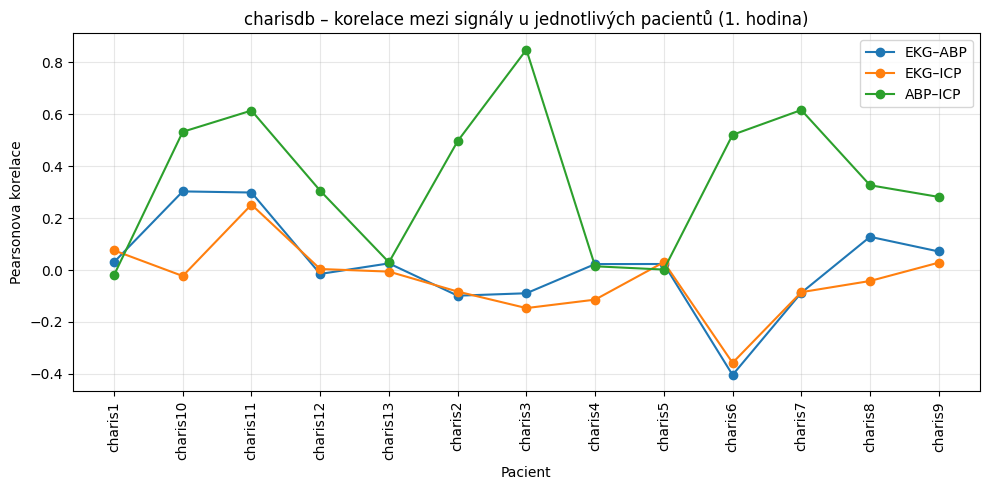

,patient_record,fs_in,fs_target,corr_ecg_abp,corr_ecg_icp,corr_abp_icp
0,charis1,50.0,125.0,0.030221,0.075600,-0.019746
1,charis10,50.0,125.0,0.302918,-0.023196,0.532624
2,charis11,50.0,125.0,0.298612,0.252015,0.614550
3,charis12,50.0,125.0,-0.015167,0.003794,0.305526
4,charis13,50.0,125.0,0.025540,-0.006155,0.029629
5,charis2,50.0,125.0,-0.099032,-0.083169,0.496573
6,charis3,50.0,125.0,-0.089624,-0.146757,0.849118
7,charis4,50.0,125.0,0.022797,-0.114215,0.014303
8,charis5,50.0,125.0,0.023168,0.030102,0.001599
9,charis6,50.0,125.0,-0.404498,-0.357769,0.520964


In [12]:
# Vybereme jen kompletní záznamy
df_pat_ok = df_pat.dropna(
    subset=["corr_ecg_abp", "corr_ecg_icp", "corr_abp_icp"]
).copy()

# Pro jistotu seřadíme podle pacienta
df_pat_ok = df_pat_ok.sort_values("patient_record")

plt.figure(figsize=(10, 5))

plt.plot(
    df_pat_ok["patient_record"],
    df_pat_ok["corr_ecg_abp"],
    marker="o",
    label="EKG–ABP"
)

plt.plot(
    df_pat_ok["patient_record"],
    df_pat_ok["corr_ecg_icp"],
    marker="o",
    label="EKG–ICP"
)

plt.plot(
    df_pat_ok["patient_record"],
    df_pat_ok["corr_abp_icp"],
    marker="o",
    label="ABP–ICP"
)

plt.xticks(rotation=90)
plt.ylabel("Pearsonova korelace")
plt.xlabel("Pacient")
plt.title("charisdb – korelace mezi signály u jednotlivých pacientů (1. hodina)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

df_pat_ok = df_pat_ok.reset_index(drop=True)
df_pat_ok


## 2.2 Korelace ABP mezi pacienty (po zarovnání)


- u každého pacienta najdu dominantní vrchol v prvních 10 s,
- signál posunu tak, aby byl vrchol na začátku,
- pak vypočítám korelační matici mezi pacienty.


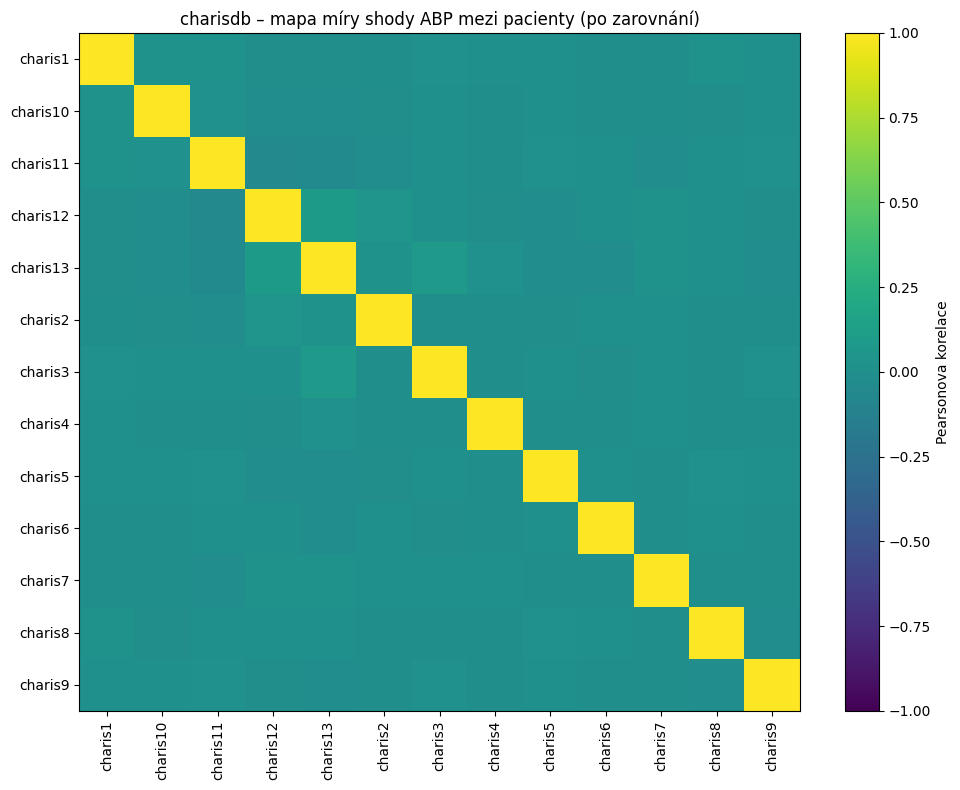

In [ ]:
# === Korelační mapa ABP mezi pacienty (po zarovnání) ===

# 1) Zarovnání ABP signálů
aligned = {}
shifts = {}

for jmeno, abp in patient_signals.items():
    abp = np.asarray(abp, dtype=float)

    # bezpečnost: NaN pryč + centralizace (kdyby nebylo)
    abp = interpolate_nans(abp)
    abp = centralize(abp)

    abp_a, posun = dominant_peak_align(abp, TARGET_FS, search_s=10.0)
    aligned[jmeno] = abp_a
    shifts[jmeno] = posun

jmena = sorted(aligned.keys())

if len(jmena) == 0:
    print("Nejsou ABP signály k vyhodnocení (zkontroluj charisdb načtení).")
else:
    # 2) Sjednocení délky (min přes všechny)
    min_len = min(len(aligned[j]) for j in jmena)
    A = np.vstack([aligned[j][:min_len] for j in jmena])

    # 3) Korelační matice (Pearson)
    C = np.corrcoef(A)
    df_C = pd.DataFrame(C, index=jmena, columns=jmena)

    # 4) Heatmapa – hezčí a čitelnější
    plt.figure(figsize=(10, 8))
    im = plt.imshow(df_C.values, aspect="auto", vmin=-1, vmax=1)
    plt.colorbar(im, label="Pearsonova korelace")

    plt.xticks(range(len(jmena)), jmena, rotation=90)
    plt.yticks(range(len(jmena)), jmena)
    plt.title("charisdb – mapa míry shody ABP mezi pacienty (po zarovnání)")
    plt.tight_layout()
    plt.show()

    # 5) tabulka
    df_C
